# **Wiki Project - Report** #

**Authors:**

**1. Kuba Czech, 156035**

**2. Wojciech Nagórka, 156045**

## **Part 1. - Scrapping and crawling** ##

In [1]:
import scrapy
import pandas as pd
from scrapy.exceptions import CloseSpider
import logging
import pandas as pd
import requests
import bs4
import re
from time import sleep
import random
from scipy.spatial.distance import cosine
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scrapy.crawler import CrawlerProcess
from nltk.tokenize import word_tokenize, wordpunct_tokenize


texts=[]
urls=[]

class MySpider(scrapy.Spider):
    name = "wiki"
    page_data = []
    allowed_domains = ["en.wikipedia.org"]
    start_urls = [
        "https://en.wikipedia.org/wiki/Pozna%C5%84_University_of_Technology",
        "https://en.wikipedia.org/wiki/Machine_learning",
        "https://en.wikipedia.org/wiki/Calculus",
    ]
    visited = []
    MAX_PAGES = 1000
    logging.disable(logging.CRITICAL)
    # Spider configuration
    custom_settings = {
        'CONCURRENT_REQUESTS': 4,
        'CONCURRENT_REQUESTS_PER_DOMAIN': 32,
        'CONCURRENT_REQUESTS_PER_IP': 32,
        'DOWNLOAD_DELAY': 2.5,
        'RANDOMIZE_DOWNLOAD_DELAY': True,
        'AUTOTHROTTLE_ENABLED': True,
        'AUTOTHROTTLE_START_DELAY': 0.1,
        'AUTOTHROTTLE_MAX_DELAY': 1,
        'AUTOTHROTTLE_TARGET_CONCURRENCY': 1,
        'DEPTH_LIMIT': 2,
        'DOWNLOADER_MIDDLEWARES': {
            'scrapy.downloadermiddlewares.referer.RefererMiddleware': None,
        },
    }

    # Page counter
    page_counter = 0

    def parse(self, response):
        global urls
        global texts
        excluded = r'Main_Page|Wikipedia|Portal|Special|Help|Talk|File|User|Category|disambiguation|#|Template|edit'

        # Increment the page counter
        self.logger.info(f"Page {self.page_counter}: {response.url}")
        print(self.page_counter)
        # Stop crawling if the page counter exceeds the maximum
        if self.page_counter >= self.MAX_PAGES:
            print("Spider done")
            self.logger.info("Maximum page limit reached. Stopping spider.")
            raise CloseSpider(reason="Maximum page limit reached")

        # Extract and process the data
        paragraphs = response.css('p').getall()
        pars = []

        for i in paragraphs:
            soup = bs4.BeautifulSoup(i)
            pars.append(soup.text)

        text = ' '.join(pars)
        if len(text)>300:
           self.page_counter += 1
           texts.append(text)
           urls.append(response.url)

        # Extract all links on the page
        links = response.css('a::attr(href)').getall()
        links = [i for i in links if not re.search(excluded, i) and i not in self.visited]
        for link in links:
            # Join relative URLs with the base URL and follow the links
            next_page = response.urljoin(link)
            self.visited.append(link)
            yield scrapy.Request(next_page, callback=self.parse)

    def closed(self, reason):
        # Save the data to a DataFrame when the spider is closed
        pages = pd.DataFrame(self.page_data)
        pages.to_csv("crawled_pages.csv", index=False)
        self.logger.info(f"Spider closed: {reason}. Total pages crawled: {len(pages)}")

In [2]:
# process = CrawlerProcess()
# process.crawl(MySpider)
# process.start()

0

 Poznań University of Technology, PUT (Polish: Politechnika Poznańska) is a university in Poznań, Poland.[3] Poznań University of Technology is known as one of the best technical universities in Poland. URAP ranked PUT among the top 6% of world universities and Webometrics ranked it at no. 842 in the world by Google citations for the year 2015. In 1995, it became the first Polish university to become a member of the Conference of European Schools for Advanced Engineering Education and Research (CESAER), an organization comprising the best technical universities in Europe. The university is also a member of the Socrates-Erasmus programme for exchange students from all over Europe, promoting advanced engineering and a European dimension. The university is home to many organizations and student circles, and the radio station Afera 98.6 MHz. The university has over 21,000 students and over 1,100 academic staff.
 There are nine faculties (since 2020):
 Poznan University of Technology (PU

## **Part 2. - Stemming and lemmatization** ##

In [2]:
def stem_documents(documents):
    porter = PorterStemmer()
    documents_stemmed = []
    for doc in documents:
        pattern = r"[\n()),.{}/']|\[\d+\]"
        result = re.sub(pattern, "", doc)

        stemmed = porter.stem(result)
        stop = stopwords.words('english')
        stems = set(stemmed.split()).difference(set(stop))
        documents_stemmed.append(" ".join(list(stems)))
    return documents_stemmed

def omitRedundantWords(documents):
    docs_omitted = []
    for doc in documents:
        # doc = " ".join([i for i in doc.split() if i != ''])
        pattern = r"[\n()),.{}/']|\[\d+\]"
        result = re.sub(pattern, "", doc)
        docs_omitted.append(result)
    return docs_omitted

In [24]:
# documents_stemmed = stem_documents(texts)
# CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
# CountData = CountVec.fit_transform(documents_stemmed)

# df=pd.DataFrame(CountData.toarray(), columns=CountVec.get_feature_names_out(), index=urls)

In [25]:
# df.columns

Index(['002', '02', '03', '04', '05', '06', '069', '07', '10', '100',
       ...
       'átha', 'éamon', 'élie', 'émile', 'ógra', 'łukasiewicz', 'łódź',
       'śląski', 'δx', 'حصبة'],
      dtype='object', length=8768)

In [26]:
# documents_stemmed

['research comprising 52°23′39″n home machinery adding polish opened anniversary kozak four 1945 poland today unfortunately put students different existed doctor championships consisting higher conducts nine jan time given technology state membership 16°55′06″e\ufeff poznań confer war organization engineers years organised part-time member world cesaer ranked office faculty allocated – advanced society exchange institution first best academic full square postgraduate managed –ects-was colleges receive founded three-time introduced projecting educational moreover 21000 engineering 80th poznańska staff imaginecup 1999 celebrated became 2000 name skłodowska-curie granted known present european remained status student urap us outbreak among education tasks politechnika dimension august \ufeff523942°n result 1995 rector technical kniat occur school host microsoft runs -time become universities autonomous september conference ieee rectors system building work thousand changed run washington 

## **Part 3. - Calculating scores and similarities** ##

In [3]:
def jaccard(d1, d2):
    union = set(d1.split()).union(set(d2.split()))
    intersect = set(d1.split()).intersection(set(d2.split()))
    return len(intersect)/len(union)

def closest(query, df):
    max_sim = 0
    max_doc = None
    for i in range(len(df)):
        doc = " ".join([df.columns[j] for j in range(len(df.columns)) if df.iloc[i][df.columns[j]] > 0])
        sim = jaccard(query, doc)
        if max_sim < sim:
            max_sim = sim
            max_doc = doc
    return max_doc

def search(query, df):
    tfidf=TfidfVectorizer(use_idf=True, smooth_idf=False)
    documents = []
    for i in range(len(df)):
        doc = " ".join([df.columns[j] for j in range(len(df.columns)) if df.iloc[i][df.columns[j]] > 0])
        documents.append(doc)
    dfTFIDF = pd.DataFrame(tfidf.fit_transform(documents).toarray(), index=df.index, columns=tfidf.get_feature_names_out())
    query = tfidf.transform([query]).toarray()[0]
    return 1-dfTFIDF.apply(lambda x: cosine(x, query), axis=1)

In [4]:
def search_engine(history, df):
    history = stem_documents(history)
    scores = []
    for doc in history:
        scores.append(search(doc, df))
    
    df = pd.concat(scores, axis = 1)
    return df.mean(axis = 1).sort_values(ascending= False)

## **Part 4. - Algorithm combining previous parts** ##

In [5]:
def scrapStemAndRecommend(viewed_documents, numberOfDocuments):
    process = CrawlerProcess()
    process.crawl(MySpider)
    process.start()

    documents_stemmed = stem_documents(texts)
    CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
    CountData = CountVec.fit_transform(documents_stemmed)

    df=pd.DataFrame(CountData.toarray(), columns=CountVec.get_feature_names_out(), index=urls)

    recommendations = search_engine(viewed_documents, df)[:numberOfDocuments]
    return recommendations

queries = [
    "plot neural network",
    "artificial intelligence machine learning data science networks",
    "data science",
    "poznan univeristy of technology is greatest erasmus kozak"
]

recommendations = scrapStemAndRecommend(queries, 10)
print("Our ranking:")
print(recommendations)

0
1
1
2
3
4
5
6
7
8
8
9
10
11
12
13
14
15
16
17
18
19
20
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
177
178
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273

## **Part 5. - Explanation of algorithm** ##

Our algorithm consists of 4 phases:

1. First we need to scrap some data from wikipedia. To achieve this we implemented our crawler that is fed with initial urls (in our example it is artile about PUT, Calculus and Machine Learning) and then it visits articles that can be accessed via links. Our limit is set to 1000 and thanks to spider configuration, we can send multiple concurrent requests. After scrapping content of the page we process gathered content to extract only pure text (and omit parts of html code) using beautiful soup. In the end we create list with strings (one string = one wikipedia article). There are two important things to mention: we scrap texts only from 'p' elements so we omit lists which may occur and to run scrapper once again you need to restart the kernel (we don't know why but that works)

2. In the second phase, we use stemming to get rid of unnecessary suffixes and word endings (it lets us decrease the number of distinct words and save time and computations). We also omit stopwords (words that have no or almost no value in terms of nlp such as we, is etc) and wikipedia references (e. g. [1]), dots, comas, brackets and newlines etc.

3. When we have list with stemmed documents our aim is to create pandas dataframe using CountVectorizer where column names are words, rows are url to each article and value for each record is how many times each word occurs in article of given URL

4. Last and most important part is search engine. It uses TF-IDF algorithm to calculate similarity between each document in df and every document previously browsed. As a result we have a list of similarities between all documents in database and proper document in history. Then, our algorithm averages similarities that were achieved and returns n wikipedia articles with highest means sorted descendingly. However, it is also possible to use Jaccard coefficient to calculate similarities, but this approach has some significatn drawbacks.

Function scrapStemAndRecommend combine all steps together, which may be not very effective because it requires a lot of scraping. Other way to utilize above functions is to read data from csv files (our database) and work on those dataframes

## **Part 6. - Interesting statistics** ##

In [6]:
documents_stemmed = stem_documents(texts)
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
CountData = CountVec.fit_transform(documents_stemmed)
df_stemmed=pd.DataFrame(CountData.toarray(), columns=CountVec.get_feature_names_out(), index=urls)


documents_not_stemmed = omitRedundantWords(texts)
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
CountData = CountVec.fit_transform(documents_not_stemmed)
df_not_stemmed = pd.DataFrame(CountData.toarray(), columns = CountVec.get_feature_names_out(), index = urls)

df_stemmed.to_csv('/Users/Kuba/Desktop/articlesDatabaseStemmed.csv')
df_not_stemmed.to_csv('/Users/Kuba/Desktop/articlesDatabaseOriginal.csv')

In [7]:
df_stemmed

,00,000,0000,00000,0000000001,000001,00001,000033,0001,000127,...,論文博士,诚信楼,邁向頂尖大學計畫,邯郸,陕北公学,雲茂潮中文图书馆,ꦈꦕꦮ,ꦩꦢ,ꦪꦠꦒꦗ,고려대학교
https://en.wikipedia.org/wiki/Pozna%C5%84_University_of_Technology,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://en.wikipedia.org/wiki/Machine_learning,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://en.wikipedia.org/wiki/Calculus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://en.wikipedia.org/wiki/List_of_universities_in_Poland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://en.wikipedia.org/wiki/Outline_of_computer_science,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://en.wikipedia.org/wiki/WSB_University,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://en.wikipedia.org/wiki/Jagiellonian_College,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://en.wikipedia.org/wiki/Independent_University_of_Business_and_Public_Administration_in_Warsaw,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://en.wikipedia.org/wiki/University_of_Social_Sciences_and_Humanities,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_not_stemmed

,00,000,0000,00000,0000000001,000001,00001,000033,0001,000127,...,論文博士,诚信楼,邁向頂尖大學計畫,邯郸,陕北公学,雲茂潮中文图书馆,ꦈꦕꦮ,ꦩꦢ,ꦪꦠꦒꦗ,고려대학교
https://en.wikipedia.org/wiki/Pozna%C5%84_University_of_Technology,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://en.wikipedia.org/wiki/Machine_learning,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://en.wikipedia.org/wiki/Calculus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://en.wikipedia.org/wiki/List_of_universities_in_Poland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://en.wikipedia.org/wiki/Outline_of_computer_science,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://en.wikipedia.org/wiki/WSB_University,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://en.wikipedia.org/wiki/Jagiellonian_College,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://en.wikipedia.org/wiki/Independent_University_of_Business_and_Public_Administration_in_Warsaw,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://en.wikipedia.org/wiki/University_of_Social_Sciences_and_Humanities,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **6.1 - statistics about words** ###

In [9]:
df_not_stemmed.describe()

,00,000,0000,00000,0000000001,000001,00001,000033,0001,000127,...,論文博士,诚信楼,邁向頂尖大學計畫,邯郸,陕北公学,雲茂潮中文图书馆,ꦈꦕꦮ,ꦩꦢ,ꦪꦠꦒꦗ,고려대학교
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.075000,0.014000,0.002000,0.001000,0.001000,0.001000,0.002000,0.001000,0.00400,0.001000,...,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
std,0.612985,0.178426,0.063246,0.031623,0.031623,0.031623,0.063246,0.031623,0.09997,0.031623,...,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,13.000000,4.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
df_not_stemmed_sums = df_not_stemmed.sum()
print(f"Word with most apearances among not stemmed text: {df_not_stemmed_sums.idxmax()}, which occured {df_not_stemmed_sums[df_not_stemmed_sums.idxmax()]} times")

df_not_stemmed_max = df_not_stemmed.max()
print(f"Word wiwth most appearances in a single not stemmed document: {df_not_stemmed_max.idxmax()}, which occured {df_not_stemmed_max[df_not_stemmed_max.idxmax()]} times")

df_not_stemmed_sums_rows = df_not_stemmed.sum(axis = 1).sort_values(ascending = False)
print(f"Longest document: {df_not_stemmed_sums_rows.index[0]}, which contained {df_not_stemmed_sums_rows[df_not_stemmed_sums_rows.index[0]]} words")
print(f"Shortest document: {df_not_stemmed_sums_rows.index[len(df_not_stemmed_sums_rows)-1]}, which contained {df_not_stemmed_sums_rows[df_not_stemmed_sums_rows.index[len(df_not_stemmed_sums_rows)-1]]} words")


Word with most apearances among not stemmed text: university, which occured 11707 times
Word wiwth most appearances in a single not stemmed document: law, which occured 382 times
Longest document: https://en.wikipedia.org/wiki/Society_of_Jesus, which contained 8168 words
Shortest document: https://en.wikipedia.org/wiki/List_of_universities_in_Bosnia_and_Herzegovina, which contained 24 words


### **6.2 - Histogram** ###

Text(0.5, 1.0, 'Number of words in articles')

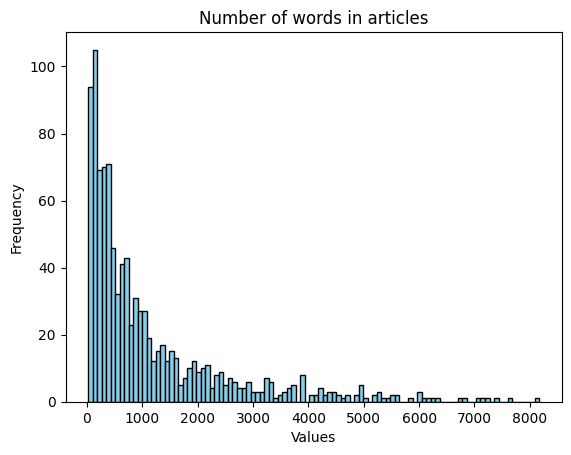

In [ ]:
import matplotlib.pyplot as plt

counts = df_not_stemmed_sums_rows.values
plt.hist(counts, bins=100, color='skyblue', edgecolor='black')
 
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Number of words in articles')

### **6.3 - Checking Zipf's Law for word occurences** ###

Zipf's Law states that:
$ r * f = constant $
where r is rank of the word and f is frequency of the word in the text. We will assume that all paragraphs combined create one single text, thus it is not necessary to divide the values by length etc

In [15]:
indexes = df_not_stemmed_sums.sort_values()[::-1].reset_index().index
nr_of_words = df_not_stemmed_sums.sort_values()[::-1].values
nr_of_words = nr_of_words[nr_of_words > 100]

const = [(indexes[i]+1) * nr_of_words[i] for i in range(len(nr_of_words))]
zipfs = pd.DataFrame({'place': range(1, len(nr_of_words)+1), 'nr_of_words': nr_of_words, 'constant': const})

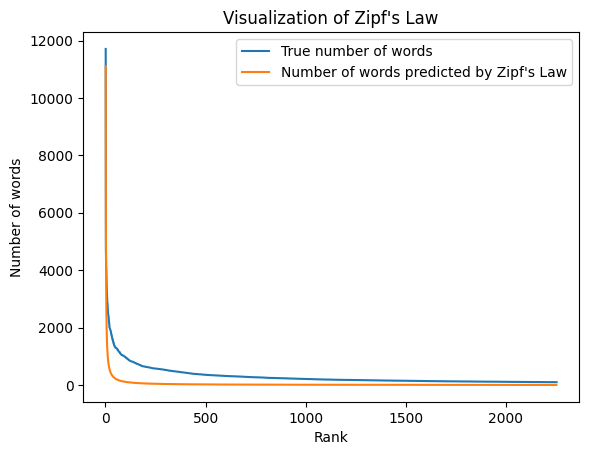

In [19]:
plt.plot(zipfs['place'], zipfs['nr_of_words'], )
plt.plot(range(1, 2254), [11107/i for i in range(1, 2254)])
plt.title("Visualization of Zipf's Law")
plt.xlabel("Rank")
plt.ylabel("Number of words")
plt.legend(['True number of words', "Number of words predicted by Zipf's Law"])
plt.show()

Orange hiperbola is what could be a prediction if we would base on Zipf's Law (proportional to 1/x). However, in nature predictions and true values are rarely the same but we can see that shapes are very similar. We filtered out words that appear less than 100 times because there are many that appear once or 5 times and it makes little sense to visualize all of them

## **Part 7. - Examples of recommendations** ##

### **Example 1 - query containing basic terms, mostly related to IT** ###

In [20]:
print("Documents in history:", queries)
print("Our recommendations")
print(recommendations)

Documents in history: ['plot neural network', 'artificial intelligence machine learning data science networks', 'data science', 'poznan univeristy of technology is greatest erasmus kozak']
Our recommendations
https://en.wikipedia.org/wiki/Pozna%C5%84_University_of_Technology                         0.053343
https://en.wikipedia.org/w/index.php?title=Outline_of_computer_science&printable=yes       0.050401
https://en.wikipedia.org/wiki/Outline_of_computer_science                                  0.050401
https://en.wikipedia.org/wiki/Soft_computing                                               0.042456
https://en.wikipedia.org/wiki/Outline_of_artificial_intelligence                           0.035951
https://en.wikipedia.org/wiki/Evolutionary_computing                                       0.035716
https://en.wikipedia.org/wiki/Computational_logic                                          0.035701
https://en.wikipedia.org/wiki/Alison_Darcy                                                 

First recommendation is here for the reason - last document in our query are words that are strictly connected to PUT so this document lead PUT article very high in our recommendations. Second of all, we see that many of above recommendations are connected to AI, CS, ML etc. This makes sense - most of previously browsed documents have some sort of 'artificial intelligence' or 'data science' terms which can be associated with this domain of sciences.

### **Example 2 - query containing fragment of an article about Calculus** ###

In [21]:
# First two paragraphs from wikipedia article on 'Calculus'
query2 = ['Calculus is the mathematical study of continuous change, in the same way that geometry is the study of shape, and algebra is the study of generalizations of arithmetic operations. Originally called infinitesimal calculus or "the calculus of infinitesimals", it has two major branches, differential calculus and integral calculus. The former concerns instantaneous rates of change, and the slopes of curves, while the latter concerns accumulation of quantities, and areas under or between curves. These two branches are related to each other by the fundamental theorem of calculus. They make use of the fundamental notions of convergence of infinite sequences and infinite series to a well-defined limit. It is the "mathematical backbone" for dealing with problems where variables change with time or another reference variable.']
print("Documents in history:", query2)
print("Our recommendations")
recommendations2 = search_engine(query2, df_stemmed)[:10]
recommendations2

https://en.wikipedia.org/wiki/Calculus                                     0.184917
https://en.wikipedia.org/wiki/Computability_theory_(computer_science)      0.084915
https://en.wikipedia.org/wiki/Matrix_(computer_science)                    0.080997
https://en.wikipedia.org/wiki/Symbolic_computation                         0.079625
https://en.wikipedia.org/wiki/Numerical_ordinary_differential_equations    0.069639
https://en.wikipedia.org/wiki/Integer                                      0.067436
https://en.wikipedia.org/wiki/Boolean_logic                                0.063172
https://en.wikipedia.org/wiki/Abstraction_(computer_science)               0.060756
https://en.wikipedia.org/wiki/Quantum_superposition                        0.057754
https://en.wikipedia.org/wiki/Scientific_modeling                          0.056354
dtype: float64

Our recommendation is as expected - most suitable recommendation is article on Calculus (the one from which we took the fragment). Other articles are reffering to domains that are strictly related to Calculus (modeling, CS etc) - also as expected.

### **Example 3 - document containing 20 most popular terms among all documents** ###

In [32]:
# query 3 = 20 most popular terms among all documents
query3 = [" ".join(df_not_stemmed_sums.sort_values(ascending = False)[:20].index)]
print("Documents in history:", query3)
print("Our recommendations")
recommendations3 = search_engine(query3, df_stemmed)[:10]
recommendations3

Documents in history: ['university school students college irish ireland new research dublin viruses used education campus time world year virus business including national']
Our recommendations


https://en.wikipedia.org/wiki/Collinstown_Park_Community_College          0.178357
https://en.wikipedia.org/wiki/The_University_Observer                     0.144212
https://en.wikipedia.org/wiki/Nova_School_of_Business_and_Economics       0.127670
https://en.wikipedia.org/wiki/Kildare_Place_National_School               0.127272
https://en.wikipedia.org/wiki/Michael_Smurfit_Graduate_Business_School    0.120973
https://en.wikipedia.org/wiki/Blackrock_Further_Education_Institute       0.116423
https://en.wikipedia.org/wiki/Portmarnock_Community_School                0.111715
https://en.wikipedia.org/wiki/University_of_Exeter_Business_School        0.109844
https://en.wikipedia.org/wiki/Shannon_College_of_Hotel_Management         0.109352
https://en.wikipedia.org/wiki/Nord_Anglia_International_School_Dublin     0.108440
dtype: float64

Among TOP20 most popular terms we have words related to education and Ireland (irish, ireland, dublin). This would explain why most suitable recommendation is Collinstown Park Community College (located in South Dublin). Besides Collinstown Park, we have more universities and schools (most of which are located in Dublin or in other parts of Ireland) - The University Observer, Kildare Place National School etc. Other factors that work on advantage of above recommendations is that above documents are relatively short - frequencies are higher than for longer documents and score are the biggest.